In [77]:
import matplotlib.pyplot as plt

In [78]:
from scipy import signal

In [79]:
from scipy import linalg

In [80]:
import numpy as np

In [81]:
import IPython

In [82]:
def plot_anc_results(e, w=None, weight_plot='response', labels=None):
    """ Plot the results of the ANC algorithm.
        @param error_history
        @param weight_history
    """
    
    if w is not None:
        fig, ax = plt.subplots(2, 1, figsize=(18, 18))
        error_ax = ax[0]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(18, 9))
        error_ax = ax
        
    if labels is None:
        labels = ['Ruido con filtrado pasivo', 'Ruido con ANC']
    for k, error in enumerate(e):
        error_ax.plot(error, label=labels[k])
    error_ax.set_ylabel('$e(n)$', fontsize=16)
    error_ax.set_xlabel('$n$', fontsize=16)
    error_ax.grid()
    error_ax.legend(loc='upper right', fontsize=14)
    
    if w is not None:
        if weight_plot == 'response':
            ax[1].stem(w, use_line_collection=True)
            ax[1].set_ylabel('$w_n$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()
        elif weight_plot == 'history':
            for i in range(w.shape[0]):
                ax[1].plot(w[i,:])
            ax[1].set_ylabel('$w_i(n)$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()
    
    plt.show()

In [83]:
def plot_frequency_analysis(p, g, w, fs):
    """ Plot the frequency responses related to the ANC system.
        P/G is the target frequency response and W is the one reached by
        the FX-LMS algorithm. G's spectrum is also shown
        @param p  P(z) impulse response
        @param g  G(z) impulse response
        @param w  W(z) impulse response
        @param fs Sampling frequency
    """
    # Calculate P/G, W and G frequency responses
    w_pg, h_pg = signal.freqz(p, g, fs=fs)
    w_w, h_w = signal.freqz(w, [1.0], fs=fs)
    w_g, h_g = signal.freqz(g, [1.0], fs=fs)

    fig, ax = plt.subplots(2, 1, figsize=(18, 10))

    ax[0].set_ylabel('Amplitud [dB]', fontsize=16)
    ax[0].set_xlabel('Frecuencia [kHz]', fontsize=16)
    ax[0].grid()
   
    ax[0].plot(w_pg / 1e3, 20*np.log10(np.abs(h_pg)), label='$P/G$')
    ax[0].plot(w_w / 1e3,20*np.log10(np.abs(h_w)), label='$W$')
    ax[0].legend(fontsize=13)
   
    ax[1].set_ylabel('Amplitud [dB]', fontsize=16)
    ax[1].set_xlabel('Frecuencia [kHz]', fontsize=16)
    ax[1].grid()
   
    ax[1].plot(w_g / 1e3,20*np.log10(np.abs(h_g)), label='$G$')
    ax[1].legend(fontsize=13)
   
    plt.show()

In [84]:
from pydsm.audio_weightings import a_weighting

In [85]:
def apply_a_weighting(f, spectrum):
    """ Applies A-Weighting to the given power spectrum
        @param f Frequency range
        @param spectrum 
        @returns weighted_spectrum
    """
    weights = a_weighting(f)
    return weights * spectrum

In [86]:
def total_attenuation(x, y, fs, nperseg):
    """ Calculate attenuation in dB
        @param x input signal
        @param y output signal
        @param fs  sampling frequency
        @param nperseg
        @returns fnn, Rnn, fee, Ree, A Attenuation in dB
    """
    # Estimate signals' power spectral density
    fnn, Rnn = signal.welch(x, fs=fs, window='hamming', nperseg=nperseg)
    fee, Ree = signal.welch(y, fs=fs, window='hamming', nperseg=nperseg)

    # Calculate energies on the time domain
    Ein = np.sum(x ** 2)
    Eout = np.sum(y ** 2)
    
    # Calculate Noise Reduction    
    A = -10*np.log10(Eout / Ein)
    
    return A, (fnn, Rnn, fee, Ree)

In [87]:
def plot_error_analysis(input_noise, output_error, fs, title, a_weighting=False):
    """ Plot power spectrum density of output signal and frequency response with 
        optional application of A-weighting
        @param input_noise System's input
        @param output_error System's output error
        @param fs Sampling frequency
        @param title Title
        @param a_weighting whether to apply A-weighting or not
    """
    # Calculate total attenuation
    A, (fnn, Rnn, fee, Ree) = total_attenuation(input_noise, output_error, fs, 2048)
    
    # Calculate frequency response
    H = Ree / Rnn
    
    # Apply A-weighting if requested
    if a_weighting:
        Ree = apply_a_weighting(fee, Ree)
        H = apply_a_weighting(fee, H)
    
    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(title + f' - Atenuación total = {A:.2f}dB', fontsize=25)

    ax[0].semilogy(fee / 1e3, Ree, label='Espectro de potencia del error de salida')
    ax[0].tick_params(labelsize=16)
    ax[0].legend(fontsize=16)
    ax[0].set_ylabel('$R_{ee}(f)$', fontsize=16)
    ax[0].set_xlabel('$f$ [kHz]', fontsize=16)
    ax[0].grid()
        
    ax[1].semilogy(fnn / 1e3, H, label=f'$E/X$')
    ax[1].tick_params(labelsize=16)
    ax[1].legend(fontsize=16)
    ax[1].set_ylabel('$Amplitudes$', fontsize=16)
    ax[1].set_xlabel('$f$ [kHz]', fontsize=16)
    ax[1].grid()

In [88]:
import json

In [89]:
class AcousticModel:
    """ The AcousticModel class exposes an inteface to simulate the interaction
        with the physical system. This allows us to encapsulate the physical model
        to easily simulate it while developing the active noise cancelling system.
    """
    
    def __init__(self):
        raise NotImplemented
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        raise NotImplemented
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        raise NotImplemented

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        raise NotImplemented
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        raise NotImplemented
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        raise NotImplemented
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        raise NotImplemented
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        raise NotImplemented

## Base de datos PANDAR
La base de datos utilizada tiene mediciones para los caminos primario, secundario y de feedback de los auriculares BoseQC20 para una cámara anecoica y una cámara acústica. Además, proveen mediciones de parte de la electrónica utilizada en las mediciones (ADC y DAC) para compensar los resultados. Este procesamiento se realiza en Matlab y se guarda el resultado en el archivo JSON accedido en este notebook.

Se utilizan las mediciones de la cámara anecoica porque al no tener reflexiones la respuesta impulsiva del camino primario es más corta, lo cual acelera los tiempos de procesamiento y agiliza el trabajo.

In [90]:
class BoseQC20(AcousticModel):
    """ Acoustic simulation of the BoseQC20 headphones based on the measurements
        performed by 
            'Acoust path database for ANC in-ear headphone development'
            Stefan LIEABICH, Johannes FABRY, Peter JAX, Peter VARY

        NOTE: It only supports simulating the primary acoustic path
    """
    
    def __init__(self, filepath, secondary_enable=False, feedback_enable=False, room='anechoic_chamber', index=0, order=2000):
        """ Initializes the BoseQC20 instance
            @param filepath Filepath to the JSON file containing the dataset
        """
        
        # Open the JSON file containing measurements of the BoseQC20 headphones
        self.acoustic_paths_filepath = filepath
        self.acoustic_paths_file = open(self.acoustic_paths_filepath, 'r')
        self.acoustic_paths_data = json.load(self.acoustic_paths_file)
        self.room = room
        self.index = index
        self.order = order
        
        self._load_measurements()
        
        # Initialize internal signals
        self.x = None                                                              # Input signal of the acoustic model for simulation
        self.y = np.zeros(len(self.g))                                             # Saves the speaker sample
        self.n = -1                                                                # Current sampling time or instant
        self.secondary_enable = secondary_enable                                   # Whether the secondary acoustic path is simulated
        self.feedback_enable = feedback_enable
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def _load_measurements(self):

        # Choose the physical or acoustic paths from the dataset
        if self.room == 'anechoic_chamber':
            self.p = self.acoustic_paths_data['anechoic_chamber']['primary'][self.index][0] # Primary acoustic path impulse response estimation
            self.g = self.acoustic_paths_data['anechoic_chamber']['secondary'][0]           # Secondary acoustic path impulse response estimation
            self.f = self.acoustic_paths_data['anechoic_chamber']['feedback'][0]            # Feedback acoustic path impulse response estimation
        elif self.room == 'acoustic_booth':       
            self.p = self.acoustic_paths_data['acoustic_booth'][self.index]['P'][0]
            self.g = self.acoustic_paths_data['acoustic_booth'][self.index]['G'][0]
            self.f = self.acoustic_paths_data['acoustic_booth'][self.index]['F'][0]
            
        # Cut the responses
        self.p = self.p[:self.order]
        self.g = self.g[:150]
        self.f = self.f[:150]
    
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(self.p, [1.0], self.x)

    def set_measurement_index(self, idx, order=None):
        """ Change the measurement index used. 
            Optionally also change the primary path's length
            Only valid for "acoustic_booth" measurements
        """
        if self.index != idx:
            self.index = idx
            if order is not None:
                self.order = order
            # Load new measurements
            self._load_measurements()
            # Re-filter the noise
            self.set_noise(self.x)
            
        
    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        # Calculate the feedback's path influence in the input measurement
        feedback_sample = np.dot(self.f, self.y) if self.feedback_enable else 0

        return self.x[self.n] + feedback_sample
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        if self.secondary_enable:
            return self.d[self.n] + np.dot(self.g, self.y)
        else:
            return self.d[self.n] + self.y[0]
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = np.roll(self.y, 1)
        self.y[0] = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

In [91]:
# Create noise samples to stimulate the acoustic system and
# validate whether the active noise cancelling system is working
fs = 48000                        # Sampling frequency
tt = 5                            # Total time of simulation
dtt = int(fs * tt)                # Discrete total time of simuluation
x_white = np.random.normal(size=dtt)

In [92]:
# Listen to the noise
IPython.display.Audio(x_white, rate=fs)

In [93]:
def anc_complete_system_nlms(model, g, f, order, step, initial_weights=None, weight_history=False, delta=1e-7):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path and compensating the 
        secondary and feedback acoustic paths.
        
        @param model Instance of an acoustic model for simulation
        @param g Secondary acoustic path
        @param f Feedback acoustic path 
        @param order Order of the filter
        @param step Step size used for LMS
        @param initial_weights Initialization of weights
        @param weight_history Enable recording the weight evolution throughout the simulation
        @return Tuple containing error and coefficients of each iteration of the LMS algorithm
                (error_signal, coefficients_evolution)
    """    
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    rg = np.zeros(len(g))      # Buffer for the input of G(z)
    rw = np.zeros(order)       # Buffer for the input of W(z)
    rlms = np.zeros(order)     # Buffer for the input of the LMS update equation
    y = np.zeros(len(f))       # Buffer for the input of F(z)
    w = np.zeros(order) if initial_weights is None else initial_weights
    e_n = np.zeros(N)
    if weight_history:
        w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        rg = np.roll(rg, 1)
        rw = np.roll(rw, 1)
        rlms = np.roll(rlms, 1)
        rg[0] = rw[0] = model.reference_microphone()
        feedback = np.dot(f, y)
        rg[0] -= feedback
        rw[0] -= feedback
        y = np.roll(y, 1)
        y[0] = -np.dot(w, rw)
        model.speaker(y[0])
        e = model.error_microphone()
        rlms[0] = np.dot(g, rg)
        w += step / ((np.dot(rw, rw) / len(rw)) + delta) * rlms * e
        e_n[i] = e
        if weight_history:
            w_n[:,i] = w
        i += 1
    
    if weight_history:
        return e_n, w, w_n
    else:
        return e_n, w

In [94]:
def plot_error_evolution(passive_noise, anc_errors, nperseg, overlap, fs):
    """ Plots the attenuation as a function of time, showing the system's adaptation
        @param passive_noise Noise that would be obtained with a passive system
        @param anc_errors    list of ANC output error for different conditions
        @param nperseg       Amount of samples used for each segment
        @param overlap       Segment overlap [0, 1.0] 
        @param fs            Sampling frequency
    """
    # Number of iterations and time axis
    N = min(len(passive_noise), len(anc_errors[0]))
    step = int(nperseg*(1 - overlap))
    it_count = int(N // step)
    t = np.linspace(0, N / fs, it_count)
    
    plt.figure(figsize=(9, 3))

    labels = ['G idéntica', 'G distinta']
    
    # Calculate energies on the time domain
    Ein = np.array([ np.sum(passive_noise[k*step:(k+1)*step] ** 2) for k in range(it_count)])
    for i in range(len(anc_errors)):
        Eout = np.array([ np.sum(anc_errors[i][k*step:(k+1)*step] ** 2) for k in range(it_count)])
        
        # Calculate Noise Reductions for each segment
        NRs = -10*np.log10(Eout / Ein)

        plt.plot(t, NRs, marker='o', label=labels[i])

    plt.ylabel("NR [dB]", fontsize=13)
    plt.xlabel("t [s]", fontsize=13)
    plt.title('Atenuación en función del tiempo', fontsize=15)
    plt.grid()
    if (len(anc_errors) > 1):
        plt.legend(fontsize=13)
    plt.show()


## Variación de P
Para validar el funcionamiento y justificar el uso de un filtro LMS adaptativo, se prueba una situación más cercana a una 
aplicación real, donde P(z) cambia en el tiempo. En la siguiente prueba, en $t=5s$ se cambian los coeficientes de P entre la primera y la tercera medición de la base de datos y se observa la adaptación del filtro. 
Nota: Usé estas mediciones porque vi que cambiaban un poco, la primera y segunda eran bastante parecidas. Se pueden ver las respuestas en frecuencia en "support/notebook/database_analysis.ipynb"

In [95]:
# Frequency responses change setup
# Measurement indexes to be used
indexes = [0, 2]
prim_paths = []
sec_paths = []
weights = []

# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True, feedback_enable=True, room='acoustic_booth', order=2000)
headphone.set_noise(x_white)

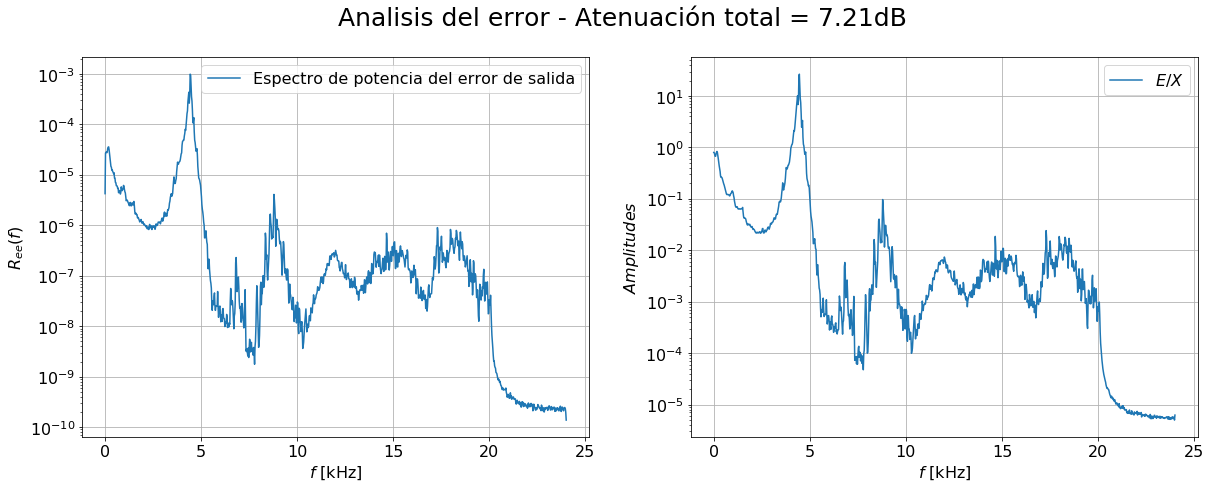

In [96]:
plot_error_analysis(x_white, headphone.d, fs, 'Analisis del error', a_weighting=False)

Analizamos la atenuación pasiva del auricular para la primera medición de cámara acústica y vemos que es de 7dB, significativamente menor a la de la cámara anecoica debido a los rebotes. Deberemos comparar contra este valor las atenuaciones obtenidas.

In [97]:
# Algorithm parameters
order = 3000
step = 0.004
w = np.zeros(order)
error = []
for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Save responses 
    prim_paths.append(headphone.p)
    sec_paths.append(headphone.g)

    # Run the algorithm
    aux_err, w = anc_complete_system_nlms(headphone, headphone.g, headphone.f, order=order, step=step, initial_weights=w)

    # Save weights and error
    weights.append(np.array(w))
    error = np.concatenate([error, aux_err])

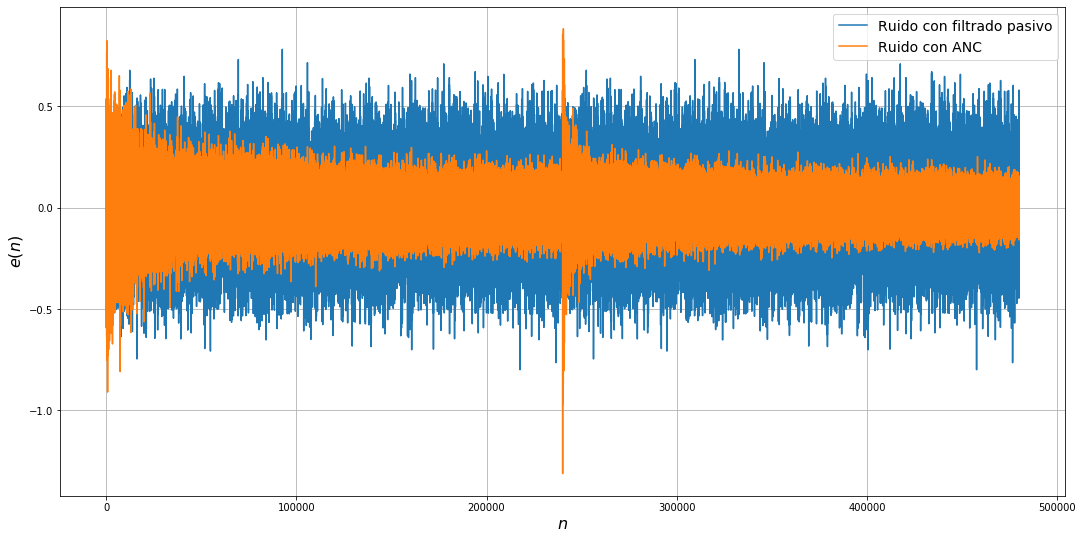

In [98]:
# Plot the ANC results
plot_anc_results([np.concatenate([headphone.d,headphone.d]), error])

Podemos observar que el filtro se adapta rápidamente al nuevo camino primario.

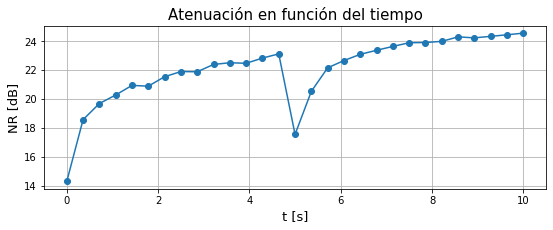

In [99]:
plot_error_evolution(np.concatenate([x_white,x_white]), [error], 8192*2, 0, fs)

En este gráfico se puede observar que la información del camino primario previo como punto de partida es mejor que los pesos iniciales nulos, dado que la NR no vuelve a su valor inicial, sino a uno más alto, y además se obtiene un valor final mayor al que se tenía antes del cambio.
Nota: Si les hacen ruido los valores de atenuacion, acordarse que son distintos a los del otro notebook porque aca usamos las mediciones de la camara acustica, no la anecoica.

In [122]:
def plot_frequency_responses(primaries, secondaries, weights, fs):
    """ Plot the frequency responses related to the ANC system.
        P/G is the target frequency response and W is the one reached by
        the FX-LMS algorithm.
        @param primaries   list of P(z) impulse responses
        @param secondaries list of G(z) impulse responses
        @param weights     list of W(z) impulse responses
        @param fs Sampling frequency
    """
    N = len(primaries)
    
    fig, ax = plt.subplots(N, 1, figsize=(15, N*5))

    plt.subplots_adjust(hspace=0.3)
    
    for k in range(N):
        # Configure plot
        ax[k].set_ylabel('Amplitud [dB]', fontsize=16)
        ax[k].set_xlabel('Frecuencia [kHz]', fontsize=16)
        ax[k].grid()
        ax[k].set_title(f'Segmento {k+1}', fontsize=18)
        
        # Calculate P/G frequency response
        f_pg, h_pg = signal.freqz(primaries[k], secondaries[k], fs=fs)
   
        # Plot P/G 
        ax[k].plot(f_pg / 1e3, 20*np.log10(np.abs(h_pg)), label=f'$P/G$')
        
        if len(weights) > 1:
            labels = ['W c/G idéntica', 'W c/G distinta']
        else:
            labels = ['W']
        # Calculate all W frequency responses
        for j in range(len(weights)):
            f_w, h_w = signal.freqz(weights[j][k], [1.0], fs=fs)
            ax[k].plot(f_w / 1e3, 20*np.log10(np.abs(h_w)), label=labels[j])
        
        ax[k].legend(fontsize=13)
      
    plt.show()

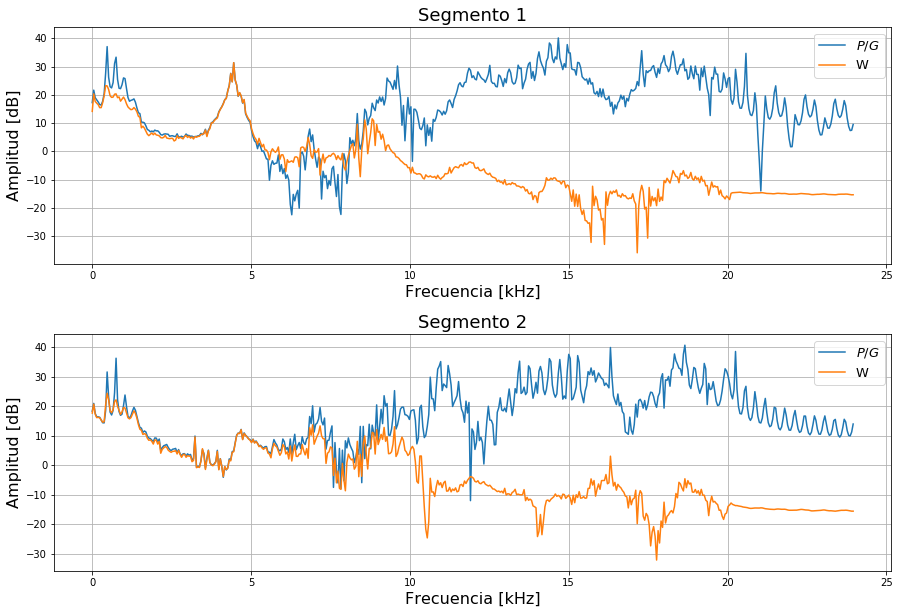

In [123]:
plot_frequency_responses(prim_paths, sec_paths, [weights], fs)

Aqui vemos que en ambos casos el sistema se pudo adaptar a P/G en cierto rango de frecuencias para ambos casos.

## Uso de otra G
Para dar un paso más hacia una aplicación real, $G(z)$ tampoco será siempre igual, por lo tanto es muy importante en esta implementacion verificar qué pasa cuando la G estimada fuera de línea no es igual al camino acústico secundario del auricular.

In [102]:
w = np.zeros(order)
error_var_g = []
weights_var_g = []

# Algorithm parameters
order = 3000
step = 0.004

headphone.set_measurement_index(1)
second_g = headphone.g
for index in indexes:
    # Set the primary path to see readaptation
    headphone.reset()
    headphone.set_measurement_index(index)
    
    # Run the algorithm
    aux_err, w = anc_complete_system_nlms(headphone, second_g, headphone.f, order=order, step=step, initial_weights=w)

    # Save weights and error
    weights_var_g.append(np.array(w))
    error_var_g = np.concatenate([error_var_g, aux_err])

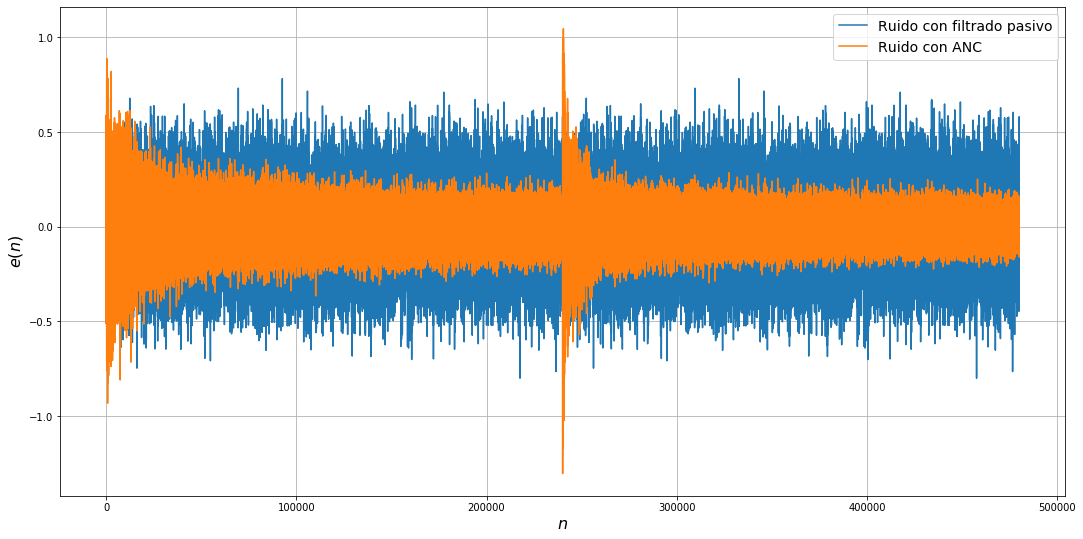

In [103]:
# Plot the ANC results
plot_anc_results([np.concatenate([headphone.d,headphone.d]), error_var_g])

Vemos que el sistema se pudo adaptar a cambios de P y G utilizando una G que no era exactamente igual a la del sistema acústico, sino que era la de otra medición. Se probó con varias G de las que tenían su pico alrededor de $4kHz$ (ref: el grafico de database_analysis.ipynb) y funcionaron. Al usar los outliers (la lila por ejemplo, con el pico en $3kHz$) deja de funcionar el sistema.
Esto nos dice que para este set de datos el sistema es robusto ante la mayoría de las G provistas. Lo que importa son los lugares donde tiene alta amplitud (el pico).

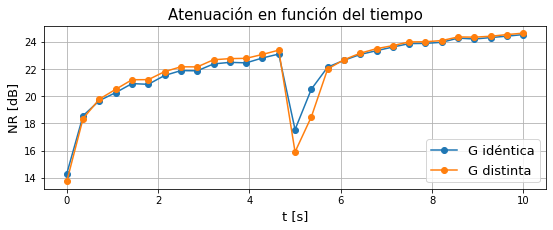

In [104]:
plot_error_evolution(np.concatenate([x_white,x_white]), [error, error_var_g], 8192*2, 0, fs)

Aquí vemos que el sistema se adapta incluso mejor utilizando esta otra G. Es posible que sea debido a sus características en frecuencia, cause menos problemas de convergencia.

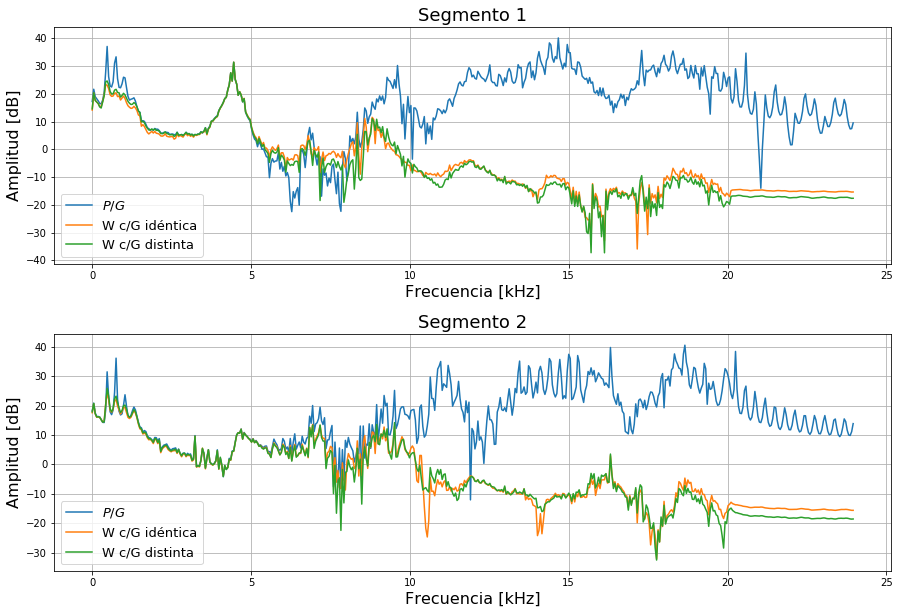

In [124]:
plot_frequency_responses(prim_paths, sec_paths, [weights, weights_var_g], fs)